In [18]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv
import io
import json
import librosa
from sklearn.model_selection import train_test_split
import librosa.display
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [72]:
# Find the name of the class with the top score when mean-aggregated across frames.
def class_names_from_csv(class_map_csv_text):
    """Returns list of class names corresponding to score vector."""
    class_map_csv = io.StringIO(class_map_csv_text)
    class_names = [display_name for (class_index, mid, display_name) in csv.reader(class_map_csv)]
    class_names = class_names[1:]  # Skip CSV header
    return class_names

In [ ]:
# Load the model.
model = hub.load('https://www.kaggle.com/models/google/yamnet/TensorFlow2/yamnet/1')


In [57]:
waveform, _ = librosa.load('Audios/vid_70.mp3', sr=16000)
waveform.shape

(128918,)

In [77]:
import librosa
import numpy as np

def load_audio_in_chunks(audio_path, chunk_duration=1.0, sample_rate=16000):
    audio, sr = librosa.load(audio_path, sr=sample_rate)
    chunk_length = int(chunk_duration * sr)  # Number of samples in each chunk
    chunks = [
        audio[i : i + chunk_length] for i in range(0, len(audio), chunk_length)
    ]
    return chunks, sr

# Example usage
audio_path = "Audios/vid_175.mp3"
chunks, sr = load_audio_in_chunks(audio_path)

# Process each chunk
for i, chunk in enumerate(chunks):
    print(f"Chunk {i+1}: {len(chunk)} samples")
    scores, embeddings, log_mel_spectrogram = model(chunk)
    class_map_path = model.class_map_path().numpy()
    class_names = class_names_from_csv(tf.io.read_file(class_map_path).numpy().decode('utf-8'))
    print(class_names[scores.numpy().mean(axis=0).argmax()])


Chunk 1: 16000 samples
Speech
Chunk 2: 16000 samples
Speech
Chunk 3: 16000 samples
Vehicle
Chunk 4: 16000 samples
Vehicle
Chunk 5: 16000 samples
Vehicle
Chunk 6: 16000 samples
Motor vehicle (road)
Chunk 7: 16000 samples
Speech
Chunk 8: 16000 samples
Music
Chunk 9: 662 samples
Silence


In [58]:
# Run the model, check the output.
scores, embeddings, log_mel_spectrogram = model(waveform)
scores.shape.assert_is_compatible_with([None, 521])
embeddings.shape.assert_is_compatible_with([None, 1024])
log_mel_spectrogram.shape.assert_is_compatible_with([None, 64])

In [60]:
class_map_path = model.class_map_path().numpy()
class_names = class_names_from_csv(tf.io.read_file(class_map_path).numpy().decode('utf-8'))
print(class_names[scores.numpy().mean(axis=0).argmax()])  # Should print 'Silence'.

Vehicle


In [61]:
embeddings.shape

TensorShape([16, 1024])

In [62]:
log_mel_spectrogram.shape

TensorShape([816, 64])

In [82]:
class AudioDataset(Dataset):
    def __init__(self, data_path=None, data=None):
        
        if data is None:
            data = np.load(data_path)

        self.embeddings = data['embeddings']
        self.labels = data['labels']

        assert len(self.embeddings) == len(self.labels), "Embeddings and labels must have the same length."

    def __len__(self):
        return len(self.embeddings) 

    def __getitem__(self, idx: int):
        return torch.tensor(self.embeddings, dtype=torch.float32), torch.tensor(self.labels, dtype=torch.float32)


In [64]:
class CNNSoundClassifier(nn.Module):
    def __init__(self, input_size, num_filters, segment_len=1000):
        super(CNNSoundClassifier, self).__init__()
        self.segment_len = segment_len

        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, num_filters, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),  
            nn.Dropout(p = 0.2),
            
            nn.Conv1d(num_filters, num_filters * 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(p = 0.2)
        )

        reduced_dim = self.segment_len // (2 * 2) 

        self.fc = nn.Linear(reduced_dim * num_filters * 2, segment_len)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.cnn(x)  # Shape: (batch_size, num_filters * 2, reduced_dim)
        x = x.view(x.size(0), -1)  # Flatten for the linear layer
        x = self.fc(x)  # Shape: (batch_size, segment_len)
        return self.sigmoid(x)


In [65]:
def extract_timestamps(predictions, hop_length, sr, merge_threshold=2, duration_threshold=1):
    """
    Extract timestamps from a binary prediction array, merging adjacent detections 
    and filtering out short detections based on duration.

    Args:
        predictions (list): Binary array of predictions (1 or 0), where 1 indicates the presence of an event.
        hop_length (int): The hop length in samples (used to calculate time from frame indices).
        sr (int): The sample rate (samples per second), used to convert indices to time.
        merge_threshold (float, optional): The minimum time gap (in seconds) between adjacent detections to consider them separate. Default is 2 seconds.
        duration_threshold (float, optional): The minimum duration (in seconds) of an event to keep. Default is 1 second.

    Returns:
        list: A list of tuples representing the start and end times of detected events (in seconds).
    """
    timestamps = []
    start = None

    for i, pred in enumerate(predictions):
        if pred > 0.5 and start is None:
            start = i
        elif pred <= 0.5 and start is not None:
            end = i
            # Convert frame indices to time and store the detected timestamp
            timestamps.append((start * hop_length / sr, end * hop_length / sr))
            start = None

    # Handle the case where an event ends at the last frame
    if start is not None:
        timestamps.append((start * hop_length / sr, len(predictions) * hop_length / sr))
    
    merged_timestamps = []
    for ts in timestamps:
        if not merged_timestamps or ts[0] - merged_timestamps[-1][1] > merge_threshold:
            # No overlap, append as new event
            merged_timestamps.append(ts)
        else:
            # Merge adjacent events into one
            merged_timestamps[-1] = (merged_timestamps[-1][0], ts[1])
    
    # Filter out events that are too short based on the duration_threshold
    merged_timestamps = [ts for ts in merged_timestamps if ts[1] - ts[0] >= duration_threshold]
    
    return merged_timestamps


In [79]:
def preprocess_all_audios(audio_files, annotations, sr=16000, root_path='Audios', save_path='preprocessed_data.npz'):
    all_embeddings = None 
    all_labels = None

    for audio_file in audio_files:
        audio_path = os.path.join(root_path, audio_file)
        waveform, _ = librosa.load(audio_path, sr=sr)

        scores, embeddings, log_mel_spectrogram = model(waveform)
        embeddings = embeddings.numpy()

        frame_length = 0.96  # seconds
        frame_hop = 0.48  # seconds

        num_embeddings = embeddings.shape[0]
        labels = np.zeros(num_embeddings)
        
        timestamps = annotations[audio_file]['crowd_noise']

        for i in range(num_embeddings):
            # Calculate start and end times for the current embedding
            start_time = i * frame_hop
            end_time = start_time + frame_length

            # Check overlap with each crowd noise interval
            for start, end in timestamps:
                overlap_start = max(start, start_time)
                overlap_end = min(end, end_time)
                overlap_duration = max(0, overlap_end - overlap_start)

                # Label as 1 if overlap exceeds half the frame length
                if overlap_duration >= (frame_length / 2):
                    labels[i] = 1
                    break  # No need to check further if labeled as 1

        # Concatenate embeddings and labels across all files
        if all_embeddings is None:
            all_embeddings = embeddings
        else:
            all_embeddings = np.concatenate((all_embeddings, embeddings), axis=0)

        if all_labels is None:
            all_labels = labels
        else:
            all_labels = np.concatenate((all_labels, labels))
    
    # Save the preprocessed data
    # np.savez_compressed(save_path, embeddings=all_embeddings, labels=all_labels)
    print(f"Saved preprocessed data: Embeddings shape {all_embeddings.shape}, Labels length {all_labels.shape}")
    
    return {'embeddings': all_embeddings, 'labels': all_labels}

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    """
    Train and validate the model for the specified number of epochs.

    Args:
        model (nn.Module): The neural network model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        criterion (nn.Module): The loss function used for training.
        optimizer (torch.optim.Optimizer): Optimizer for updating model weights.
        epochs (int, optional): Number of training epochs. Defaults to 10.

    Returns:
        None
    """
    model.train()

    for epoch in range(epochs):
        total_train_loss = 0
        train_correct_predictions = 0
        train_total_samples = 0

        for embeddings, labels in train_loader:
            optimizer.zero_grad()

            outputs = model(embeddings)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            optimizer.step() 

            total_train_loss += loss.item()

            predictions = (outputs.squeeze() > 0.5).float()
            train_correct_predictions += (predictions == labels).sum().item()
            train_total_samples += labels.numel()

        # Calculate average training loss and accuracy for this epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = train_correct_predictions / train_total_samples

        model.eval()

        total_val_loss = 0
        val_correct_predictions = 0
        val_total_samples = 0

        with torch.no_grad():
            for mel_spec, labels in val_loader:
                outputs = model(mel_spec)

                loss = criterion(outputs.squeeze(), labels.squeeze())
                total_val_loss += loss.item()

                predictions = (outputs.squeeze() > 0.5).float()
                val_correct_predictions += (predictions == labels).sum().item()
                val_total_samples += labels.numel()

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = val_correct_predictions / val_total_samples

        print(f"Epoch {epoch+1}/{epochs} -> "
            f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4%}, "
            f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4%}")

In [106]:
# Hop Length: Number of samples between consecutive frames in the spectrogram
HOP_LENGTH = 64
# Number of Mel frequency bands for Mel spectrogram
N_MELS = 64
# Sample rate of the audio (samples per second)
SAMPLE_RATE = 16000
# Hidden size of the LSTM layer (number of LSTM units)
# HIDDEN_SIZE = 64
# Maximum length of the input sequence (number of frames)
SEGMENT_LEN = 1000
# Training number of epochs
EPOCHS = 10
# Audios root directory path
DATASET_ROOT_DIRECTORY = 'Audios'

LEARNING_RATE = 0.0001

# LEARNING_RATE = 1e-4  # Adjust this based on experimentation
WEIGHT_DECAY = 1e-4  # Appropriate weight decay for small dataset

In [107]:
# Define the classifier head
class ClassifierHead(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        """
        A simple classifier head to predict binary labels from embeddings.

        Args:
            input_dim (int): Dimensionality of the input embeddings.
            hidden_dim (int): Number of units in the hidden layer.
        """
        super(ClassifierHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(hidden_dim, 1) 
        self.sigmoid = nn.Sigmoid() 

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [89]:
# Load annotations from JSON file
with open("timestamp_annotations.json", "r") as f:
    annotations = json.load(f)

# Extract the audio files from the annotations
audio_files = list(annotations.keys())

# Split the dataset into training and validation sets (80% training, 20% validation)
train_files, val_files = train_test_split(audio_files, test_size=0.2, random_state=42)

train_data = preprocess_all_audios(train_files, annotations, root_path=DATASET_ROOT_DIRECTORY)

val_data = preprocess_all_audios(val_files, annotations, sr=SAMPLE_RATE, root_path=DATASET_ROOT_DIRECTORY)

# # Initialize the datasets
train_dataset = AudioDataset(
    data = train_data,
)

val_dataset = AudioDataset(
    data = val_data,
)

# Create DataLoader instances for both training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


Saved preprocessed data: Embeddings shape (1504, 1024), Labels length (1504,)
Saved preprocessed data: Embeddings shape (430, 1024), Labels length (430,)


In [108]:
# Initialize the model, loss function, and optimizer
# model = LSTMSoundClassifier(input_size=N_MELS, hidden_size=HIDDEN_SIZE, num_layers=1, output_size=1)
model = ClassifierHead(input_dim=1024)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS)

Epoch 1/10 -> Train Loss: 0.3897, Train Accuracy: 83.5704%, Val Loss: 0.3503, Val Accuracy: 84.4186%
Epoch 2/10 -> Train Loss: 0.2579, Train Accuracy: 89.7186%, Val Loss: 0.3709, Val Accuracy: 83.7209%


In [104]:
def create_confusion_matrix_and_report(model, val_loader):
    """
    Evaluates the model using the validation data loader and computes the confusion matrix and classification report.
    
    Args:
        model (torch.nn.Module): The trained model.
        val_loader (DataLoader): DataLoader containing validation data.
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []  # List to store all predictions
    all_labels = []  # List to store all true labels

    with torch.no_grad():  # Disable gradient computation during evaluation
        for embeddings, labels in val_loader:

            outputs = model(embeddings)
            predictions = (outputs.squeeze() > 0.5).float()
            
            all_preds.extend(predictions.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Calculate confusion matrix using true and predicted labels
    cm = confusion_matrix(all_labels, all_preds, labels=[1, 0])  # 1 = Cheering, 0 = No Cheering
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cheering", "No Cheering"])

    # Print classification report (precision, recall, f1-score, etc.)
    report = classification_report(all_labels, all_preds, target_names=["No Cheering", "Cheering"])
    print(report)

    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

              precision    recall  f1-score   support

 No Cheering       0.89      0.87      0.88    138030
    Cheering       0.64      0.68      0.66     46870

    accuracy                           0.82    184900
   macro avg       0.77      0.78      0.77    184900
weighted avg       0.83      0.82      0.82    184900



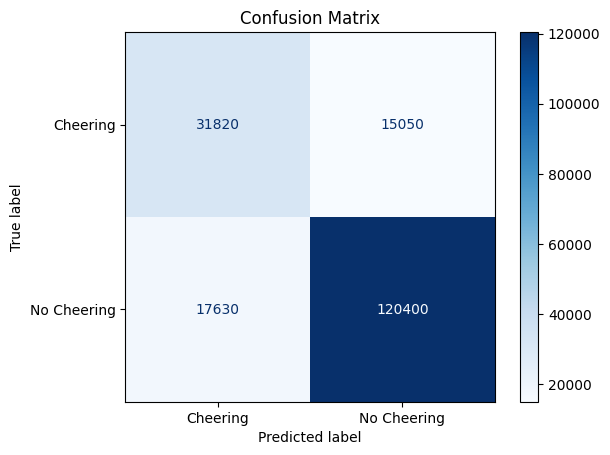

In [105]:
create_confusion_matrix_and_report(model, val_loader)